In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
df_train= pd.read_csv('train.csv')
df_train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
df_train.shape

(878049, 9)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [5]:
#check for duplicated values
df_train.duplicated().sum()

2323

In [6]:
#drop duplicated values
df_train.drop_duplicates(keep = 'first', inplace = True)
df_train.shape

(875726, 9)

In [7]:
df_train.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')

In [8]:
df_train.nunique()

Dates         389257
Category          39
Descript         879
DayOfWeek          7
PdDistrict        10
Resolution        17
Address        23228
X              34243
Y              34243
dtype: int64

In [9]:
df_train.Category.value_counts()

Category
LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUN

In [10]:
df_train.Resolution.value_counts()

Resolution
NONE                                      525122
ARREST, BOOKED                            206173
ARREST, CITED                              76832
LOCATED                                    16889
PSYCHOPATHIC CASE                          14529
UNFOUNDED                                   9577
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3969
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3710
JUVENILE CITED                              3322
PROSECUTED BY OUTSIDE AGENCY                2503
EXCEPTIONAL CLEARANCE                       1528
JUVENILE ADMONISHED                         1451
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: count, dtype: int64

In [11]:
df_train['Dates'] = pd.to_datetime(df_train['Dates'])

df_train['year'] = df_train['Dates'].dt.year
df_train['month'] = df_train['Dates'].dt.month
df_train['day_of_month'] = df_train['Dates'].dt.day
df_train['day_of_week'] = df_train['Dates'].dt.day_of_week
df_train['hour'] = df_train['Dates'].dt.hour
df_train.drop(['Dates', 'DayOfWeek'], axis = 1, inplace = True)
df_train.dtypes

Category         object
Descript         object
PdDistrict       object
Resolution       object
Address          object
X               float64
Y               float64
year              int32
month             int32
day_of_month      int32
day_of_week       int32
hour              int32
dtype: object

In [12]:
df_train.columns = [item.lower() for item in df_train.columns]

In [13]:
pd.crosstab(df_train['day_of_week'], df_train['category'])

category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,228,10550,66,41,5239,607,263,7812,512,222,...,23,636,75,4445,1,1080,5916,7401,5804,1182
1,235,10268,76,37,5356,657,251,8463,461,156,...,23,713,66,4513,1,1113,5844,7262,6412,1176
2,200,10549,71,40,5430,658,221,9259,541,165,...,22,699,66,4849,0,1120,5904,7393,7009,1251
3,199,10236,66,39,5336,643,282,8447,496,165,...,15,678,89,4504,1,1046,5968,7449,6365,1281
4,220,11155,62,49,6302,540,352,7415,621,211,...,28,647,72,4921,1,1062,7071,8597,5921,1302
5,219,11987,45,42,4732,624,457,6385,833,137,...,21,581,73,4154,2,982,7301,8108,5355,1231
6,211,12070,20,41,4205,584,442,6138,813,108,...,16,583,67,4008,0,915,6577,7496,5279,1127


In [14]:
df_train.columns

Index(['category', 'descript', 'pddistrict', 'resolution', 'address', 'x', 'y',
       'year', 'month', 'day_of_month', 'day_of_week', 'hour'],
      dtype='object')

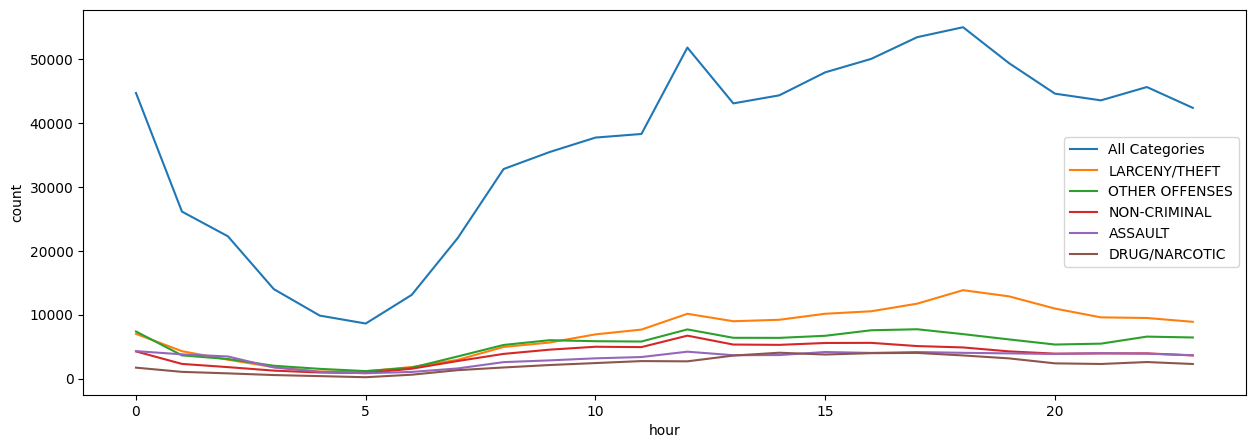

In [15]:
category_count = df_train.category.value_counts().to_frame().reset_index()
top5category = category_count.iloc[:5] 
# print(top5category)

df_cat = df_train.hour.value_counts().to_frame().sort_index()
plt.figure(figsize = (15, 5))
plt.plot(df_cat)

for item in top5category.index:
    df_cat = df_train[df_train.category == top5category.iloc[item].category].hour.value_counts().to_frame().sort_index()
    plt.plot(df_cat)
plt.legend(['All Categories'] + list(top5category.category))
plt.xlabel('hour')
_ = plt.ylabel('count')

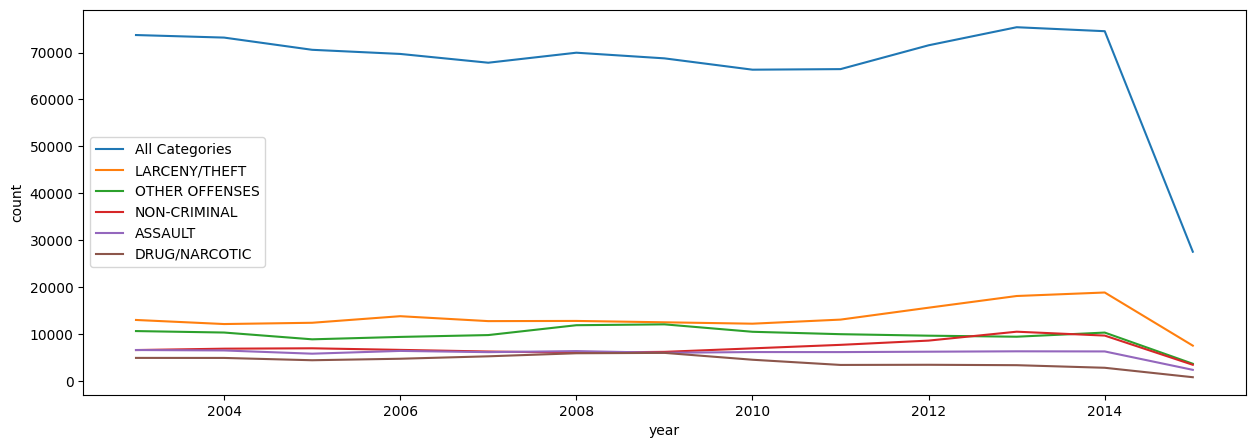

In [16]:
category_count = df_train.category.value_counts().to_frame().reset_index()
top5category = category_count.iloc[:5] 

df_cat = df_train.year.value_counts().to_frame().sort_index()
plt.figure(figsize = (15, 5))
plt.plot(df_cat)

for item in top5category.index:
    df_cat = df_train[df_train.category == top5category.iloc[item].category].year.value_counts().to_frame().sort_index()
    plt.plot(df_cat)
plt.legend(['All Categories'] + list(top5category.category))
plt.xlabel('year')
_ = plt.ylabel('count')

<Axes: xlabel='pddistrict', ylabel='category'>

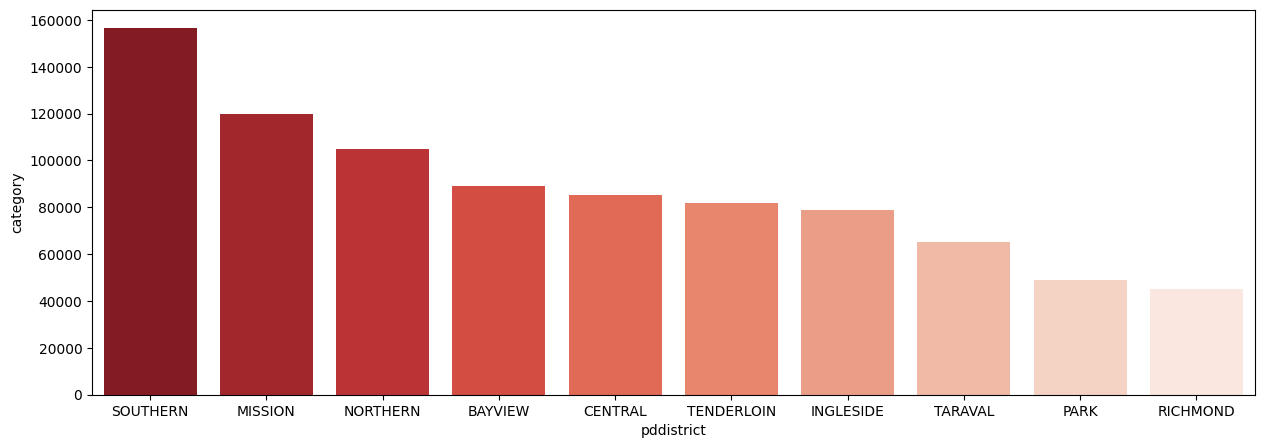

In [17]:
df1 = df_train.groupby('pddistrict').count().reset_index()[['pddistrict', 'category']].sort_values('category', ascending = False)
plt.figure(figsize = (15, 5))
sns.barplot(x = 'pddistrict',y = 'category',data = df1, palette= 'Reds_r')

Data preprocessing

In [27]:
df_train2 = df_train.iloc[ : 200, :]
df_train2.head()

,category,descript,pddistrict,resolution,address,x,y,year,month,day_of_month,day_of_week,hour
0,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,2,23
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,2,23
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,2,23
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,2,23
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,2,23


In [28]:
# Variable Encoding
top200 = df_train['descript'].value_counts()[:200].index
df_train2['descript'] = df_train2['descript'].apply(lambda x :x if x in top200 else 'other' )
x = df_train2.drop(['category', 'address'], axis = 1)
y = df_train2['category']
x.head()

C:\Users\noora\AppData\Local\Temp\ipykernel_8524\115127614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2['descript'] = df_train2['descript'].apply(lambda x :x if x in top200 else 'other' )


,descript,pddistrict,resolution,x,y,year,month,day_of_month,day_of_week,hour
0,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",-122.425892,37.774599,2015,5,13,2,23
1,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",-122.425892,37.774599,2015,5,13,2,23
2,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",-122.424363,37.800414,2015,5,13,2,23
3,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,-122.426995,37.800873,2015,5,13,2,23
4,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,-122.438738,37.771541,2015,5,13,2,23


In [29]:
x.shape, y.shape

((200, 10), (200,))

In [85]:
le = LabelEncoder()
y = le.fit_transform(y)

x['descript'] = le.fit_transform(x['descript'])
x['pddistrict'] = le.fit_transform(x['pddistrict'])
x['resolution'] = le.fit_transform(x['resolution'])
x.head()

,descript,pddistrict,resolution,x,y,year,month,day_of_month,day_of_week,hour
0,65,4,0,-122.425892,37.774599,2015,5,13,2,23
1,60,4,0,-122.425892,37.774599,2015,5,13,2,23
2,60,4,0,-122.424363,37.800414,2015,5,13,2,23
3,24,4,3,-122.426995,37.800873,2015,5,13,2,23
4,24,5,3,-122.438738,37.771541,2015,5,13,2,23


In [21]:
#y.head()

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 1)
print('x train :', x_train.shape,'\t\tx test :', x_test.shape)
print('y train :', y_train.shape,'\t\ty test :', y_test.shape)

x train : (170, 10) 		x test : (30, 10)
y train : (170,) 		y test : (30,)


In [88]:
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

In [89]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

len(np.unique(y_test))
len(np.unique(y_train))

17

In [90]:
#Train your model
dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(x_test, label=y_test, enable_categorical=True)

# Set the XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 39,
    'max_depth': 3,
    'eta': 0.1
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

In [91]:
# Make predictions on the testing data
y_pred = xgb_model.predict(dtest)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6


In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, cohen_kappa_score, log_loss
import matplotlib.pyplot as plt

In [95]:
test_data  = pd.read_csv('test.csv',index_col=0)
test_data2 = test_data.iloc[: 50000, :] 
# test_data['RANDOM'] = np.random.normal(size=len(test_data))
X_examine = test_data2

le2 = LabelEncoder()
X_examine['PdDistrict'] = le2.fit_transform(X_examine['PdDistrict'])
X_examine['DayOfWeek'] = le2.fit_transform(X_examine['DayOfWeek'])
X_examine['Address'] = le2.fit_transform(X_examine['Address'])
X_examine['Address'] = le2.fit_transform(X_examine['Address'])


X_examine['Dates'] = pd.to_datetime(X_examine['Dates'])
X_examine['year'] = X_examine['Dates'].dt.year
X_examine['month'] = X_examine['Dates'].dt.month
X_examine['day_of_month'] = X_examine['Dates'].dt.day
X_examine['day_of_week'] = X_examine['Dates'].dt.day_of_week
X_examine['hour'] = X_examine['Dates'].dt.hour

X_examine = X_examine.drop(["Dates"], axis=1)

X_examine = X_examine.fillna(X_examine.mean())

X_examine.head()

submission = xgb_model.predict(xgb.DMatrix(X_examine.values))

pd.DataFrame({"Id":X_examine.index, "category":submission}).to_csv("submission-san-francisco.csv", index=False)

C:\Users\noora\AppData\Local\Temp\ipykernel_8524\522463565.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_examine['PdDistrict'] = le2.fit_transform(X_examine['PdDistrict'])
C:\Users\noora\AppData\Local\Temp\ipykernel_8524\522463565.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_examine['DayOfWeek'] = le2.fit_transform(X_examine['DayOfWeek'])
C:\Users\noora\AppData\Local\Temp\ipykernel_8524\522463565.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram